## 1. Getting ready for work

In [2]:
# Import of necessary modules for further work
import vk_api
import time
import functools
import datetime
import numpy as np
import pandas as pd
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Congiguring general data visualisation settings
sns.set(
    rc = {
        "figure.figsize" :(7,3),
        "axes.titlesize" : 16,
        "axes.labelsize" : 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    },
    style = 'ticks',
    palette = 'deep'
)

## 2. Authorisation and access to VK API

In [4]:
token = 'vk1.a.jkaBE_lq0gr2zG1OKDzXiEVNnapzL34Lzd7TUe6kmsWOFcbCctVgag2YEKqyjdgiqtcURX7Wf64tDTGDwJ1j1R_yP4LHKqBYj15_AWrnoaZ-rPQf_ZTiGwUXwRGS9VojCjFCPCNmY045CZklBiWJPw9iabfvyrj32nRmns-Z779hYRzLlyxYgIRXN3bxmwgaIB85d8dr8Jmv9Z4ubpqHrw'

In [5]:
vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()

## 3. Obtaining and processing user data

In [6]:
def get_group_members(group_id: str, members: list, offset: int) -> list:
    '''
    This functions returns information
    about users of the specified VK community
    
    Parameters
    ----------
    group_id : string
        group id, users of which to be obtained.
    members: list
        origin users list.
    offset: 
        shifting the number of users on repeated request
        
    Returns users info as object
    '''
    if offset == 20000: return np.array(members).flatten().tolist()
    
    user_ids = vk.groups.getMembers(
        group_id = group_id,
        offset = offset,
        count = 1000 ,
        fields = [
            'sex',
            'bdate',
            'relation',
            'city',
            'home_town',
            'country',
            'university_name',
            'followers_count',
            'personal'
        ]
    )
    
    members.append((user_ids['items']))
    offset += 1000 
    time.sleep(3) # Request is every 3 seconds
        
    return get_group_members(group_id, members, offset)

In [7]:
raw_members = list(filter(lambda x: x['is_closed'] == False, get_group_members('typical_yasnogorsk', [], 0)))

In [8]:
users_data = pd \
    .DataFrame(raw_members) \
    .drop(['can_access_closed','is_closed', 'deactivated', 'relation_partner'], axis=1) \
    .dropna()

users_data = users_data \
    .assign(
        current_city = users_data['city'].apply(lambda x: x['title']),
        current_country = users_data['country'].apply(lambda x: x['title'])) \
    .drop(['city', 'country'], axis=1) \
    .astype({'followers_count':'int64', 'relation':'int64'})

## 4.Data handling
#### Data has been taken from the VK community with name "Typical Yasnogorsk". The data are presented in the following form:
- user ID (id)
- year of birth (bdate)
- sex (sex)
- current city (city)
- home town (home_town)
- relation (relation)
- country (country)
- number of followers (followers_count)

### 4.1 Users Distribution By Sex

In [9]:
# Users Distribution By Sex
users_by_sex = users_data \
    .groupby('sex', as_index=False) \
    .agg({'id':'count'}) \
    .replace({'sex':{
        0:'Unknown',
        1:'Female',
        2:'Male'}
    }) \
    .rename(columns={'id':'users_count'})

### 4.2 Users Distribution By Age

In [10]:
# Add column with year of birth 
users_data['byear'] = users_data.bdate.apply(lambda x: x.split('.')[-1])
users_data['byear'] = np.where(users_data.byear.str.len() != 4, np.nan, users_data.byear)
users_data = users_data.dropna(subset='byear').astype({'byear':'int64'})
users_data = users_data.assign(age = datetime.date.today().year - users_data.byear)

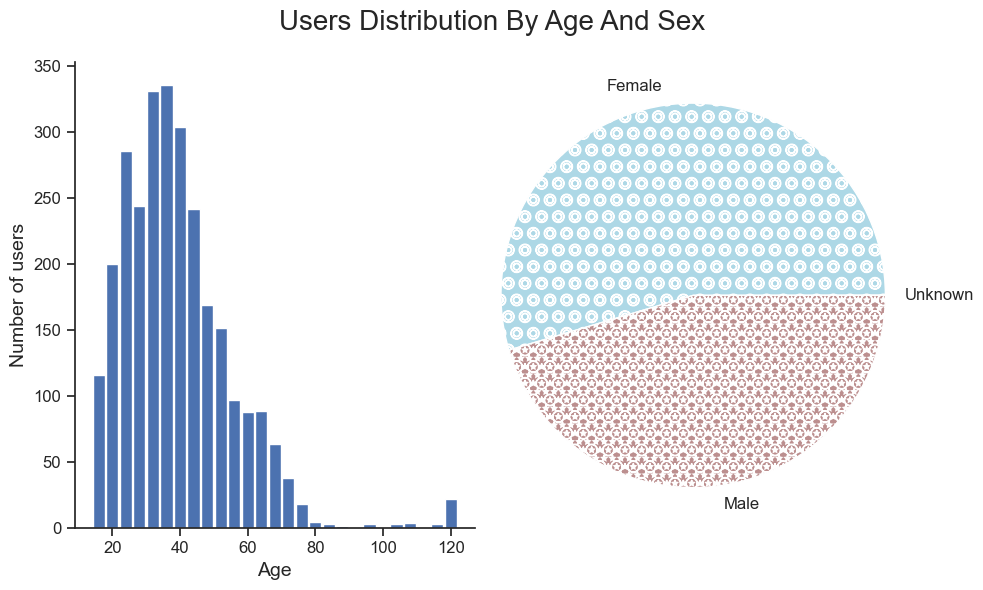

In [11]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
figure.suptitle(
    t='Users Distribution By Age And Sex',
    fontsize=20
)
figure.set_tight_layout(True)

ax1.hist(
    users_data.age,
    bins=int(1 + 3.332 * np.log(2820)),
    rwidth=0.9,
    edgecolor="white")

ax1.set(
    xlabel = 'Age',
    ylabel = 'Number of users'
)
ax2.pie(
    x = users_by_sex.users_count.to_list(),
    labels = users_by_sex.sex.to_list(),
    radius = 1.2,
    colors = ['rosybrown', 'lightblue'],
    hatch=['**O', 'oO']
)

plt.subplots_adjust(top=0.8)
sns.despine()

plt.savefig(
    fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/age_and_sex',
    format = 'png',
    bbox_inches = 'tight'
)

### 4.3 Users Distribution By Age Categories

In [12]:
# Add column with age category
users_data = users_data.assign(age_cat = pd.cut(
    users_data.age,
    bins = [0, 12, 18, 65, float('inf')],
    labels=['children', 'adolescents', 'adult', 'older adult']))

In [13]:
# Split users by age categories
users_by_age = users_data \
    .groupby('age_cat', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .sort_values('users_count', ascending=False)

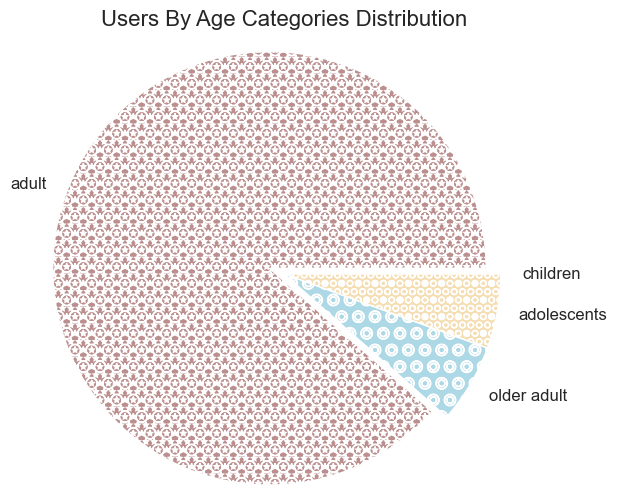

In [14]:
# Distribution Visualization
labels = users_by_age.age_cat.to_list()
sizes = users_by_age.users_count.to_list()
explode = (0.1, 0, 0, 0)

figure, axes = plt.subplots()

axes.pie(
    sizes,
    labels=labels,
    explode=explode,
    radius = 1.4,
    colors = [
        'rosybrown',
        'lightblue',
        'wheat',
        'pink'
    ],
    hatch=['**O', 'oO', 'O.O', '.||.']
)
axes.set(
    title = 'Users By Age Categories Distribution\n\n'
)

plt.subplots_adjust(top = 1.4)
sns.despine()

plt.savefig(
    fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/age',
    format = 'png',
    bbox_inches = 'tight'
)

### 4.4 Users Distribution By Current City

In [15]:
# Users Distribution By Current City
top_users_by_ht = users_data \
    .groupby('current_city', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .sort_values('users_count', ascending=False) 

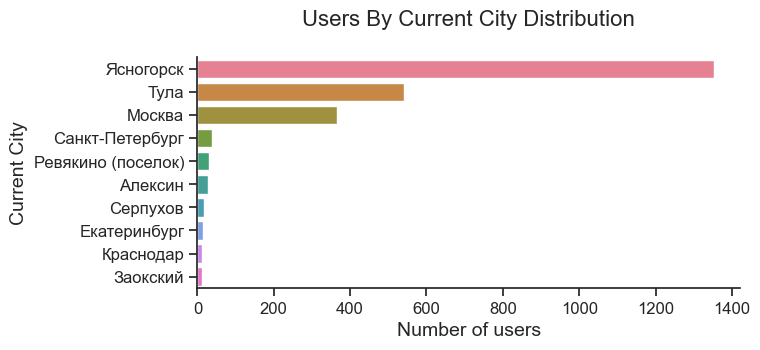

In [16]:
# Distribution Visualisation
top_users_by_ht_dist = sns.barplot(
    x='users_count',
    y='current_city',
    data=top_users_by_ht.head(10),
    palette = 'husl'
)
top_users_by_ht_dist.set(
    title = 'Users By Current City Distribution\n',
    ylabel = 'Current City',
    xlabel = 'Number of users'
)

sns.despine()

plt.savefig(
    fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/city_distribution',
    format = 'png',
    bbox_inches = 'tight'
)

### 4.5 Users Distribution By Relation

In [17]:
# Add column with relation category
bins = [i for i in range(-1, 9)]
users_data['relation_cat'] = pd.cut(
    users_data.relation,
    bins = bins,
    labels = [
        'unknown',
        'single',
        'has partner',
        'engaged',
        'married',
        'complicated',
        'search',
        'in love',
        'civil marriage'
    ]
)

In [18]:
# Users Distribution By Relation
users_by_relation = users_data \
    .groupby('relation_cat', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .sort_values('users_count', ascending=False)

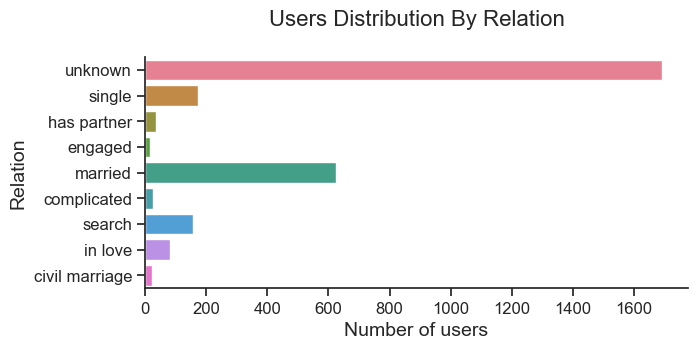

In [19]:
# Distribution Visualisation
users_by_relation_dist = sns.barplot(
    x='users_count',
    y='relation_cat',
    data=users_by_relation,
    palette = 'husl')
users_by_relation_dist.set(
    title = 'Users Distribution By Relation\n',
    xlabel = 'Number of users',
    ylabel = 'Relation'
)

sns.despine()

plt.savefig(
    fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/relation',
    format = 'png',
    bbox_inches = 'tight'
)

### 4.6 Users Distribution By Countries

In [20]:
# Users Distribution By Countries
top_countries = users_data \
    .groupby('current_country', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .sort_values('users_count', ascending=False) \
    .head(3)

##  5. Personal User Info Processing

In [21]:
# Add column with personal info to filter columns
users_data['has_personal_info'] = users_data.personal.apply(lambda x: type(x) == list)
users_data = users_data[users_data.has_personal_info == False]

In [22]:
def get_value(info: dict, key: str):
    '''
    This function returns a value from the dictionary,
    if there is a corresponding key. Otherwise
    NaN is returned
    
    Parameters
    ----------
    info : dict
        dict should be processed
    key: str
        corresponding key for returning value
    '''
    try:
        return info[key]
    except:
        return np.nan

In [23]:
# Add columns with personal info to process
users_data = users_data \
    .assign(
        languages   = users_data.personal.apply(lambda x: get_value(x, 'langs')).fillna('unknown'),
        religion    = users_data.personal.apply(lambda x: get_value(x, 'religion')).fillna('unknown'),
        political   = users_data.personal.apply(lambda x: get_value(x, 'political')).fillna('unknown'),
        people_main = users_data.personal.apply(lambda x: get_value(x, 'people_main')).fillna('unknown'),
        life_main   = users_data.personal.apply(lambda x: get_value(x, 'life_main')).fillna('unknown'),
        smoking     = users_data.personal.apply(lambda x: get_value(x, 'smoking')).fillna('unknown'),
        alcohol     = users_data.personal.apply(lambda x: get_value(x, 'alcohol')).fillna('unknown')
    ) \
    .explode('languages') \
    .drop('personal', axis=1)

### 5.1 Users Distribution By Attitude to Bad Habits Like Alcohol And Smoking

In [24]:
# Split users by their attitude to smoking
users_by_smoking = users_data \
    .loc[~users_data.smoking.isin(['unknown', 0])] \
    .groupby('smoking', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .replace({'smoking':{
        1:'strictly negative',
        2:'negative',
        3:'compromiss',
        4:'neutral',
        5:'positive'
    }}) \
    .sort_values('smoking')

In [25]:
# Split users by their attitude to alcohol
users_by_alcohol = users_data \
    .loc[~users_data.alcohol.isin(['unknown', 0])] \
    .groupby('alcohol', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .replace({'alcohol': {
        1:'strictly negative',
        2:'negative',
        3:'compromiss',
        4:'neutral',
        5:'positive'
    }}) \
    .sort_values('alcohol')

In [26]:
smoking_names = users_by_smoking.smoking.to_list()
smoking_user_count = users_by_smoking.users_count.to_list()
alcohol_names = users_by_alcohol.alcohol.to_list()
alcohol_user_count = users_by_alcohol.users_count.to_list()

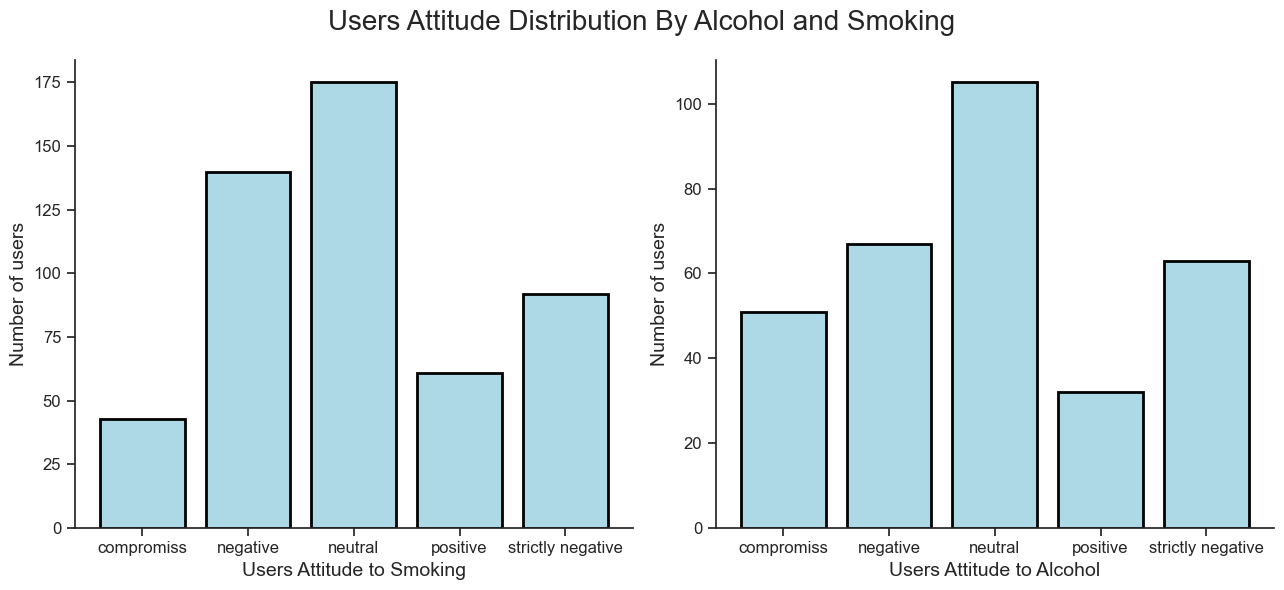

In [27]:
# Distribution Visualisation
figure, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 6), sharex = True)
figure.suptitle(
    t = 'Users Attitude Distribution By Alcohol and Smoking',
    fontsize = 20
)
figure.set_tight_layout(True)

ax1.bar(
    x=smoking_names,
    height=smoking_user_count,
    color='lightblue',
    ec = 'black',
    lw=2
)
ax1.set_ylabel('Number of users')
ax1.set_xlabel('Users Attitude to Smoking')

ax2.bar(
    x=alcohol_names,
    height=alcohol_user_count,
    color='lightblue',
    ec='black',
    lw=2
)
ax2.set_ylabel('Number of users')
ax2.set_xlabel('Users Attitude to Alcohol')

sns.despine()

# plt.savefig(
#     fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/smoking_and_alco',
#     format = 'png',
#     bbox_inches = 'tight'
# )

### 5.2 Users Distribution By Political Views

In [28]:
# Users Distribution By Political Views
users_by_politic = users_data \
    .loc[~users_data.political.isin(['unknown', 0])] \
    .groupby('political', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .replace({'political': {
        1:'communism',
        2:'socialism',
        3:'moderate',
        4:'liberalism',
        5:'conservatism',
        6:'monarchism',
        7:'ultraconservatism',
        8:'indifference',
        9:'libertarianism'
    }}) \
    .sort_values('political')

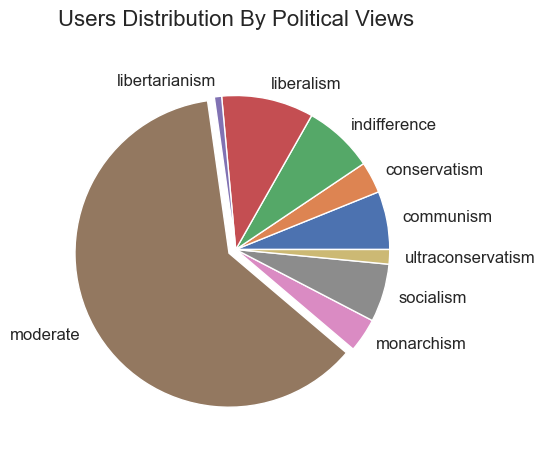

In [29]:
# Distribution Visualisation
labels = users_by_politic.political.to_list()
sizes  = users_by_politic.users_count.to_list()
explode = (0, 0, 0, 0, 0, 0.05, 0, 0, 0)

figure, axes = plt.subplots(figsize=(15,5))
axes.pie(
    sizes,
    labels=labels,
    explode=explode
)
axes.set(title = 'Users Distribution By Political Views\n')

sns.despine()

#Saving Distribution
plt.savefig(
    fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/political_views',
    format = 'png',
    bbox_inches = 'tight'
)

### 5.3 Users Distribution By People and Life Values

In [30]:
# Users Distribution By People Values
users_by_people_main = users_data \
    .loc[~users_data.people_main.isin(['unknown', 0])] \
    .groupby('people_main', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .replace({'people_main':{
        1:'intelligence', 
        2:'honesty and kindness',
        3:'beauty and health',
        4:'wealth',
        5:'courage',
        6:'cheerfulness'
    }}) \
    .sort_values('people_main')

In [31]:
# User Distribution By Life Values
users_by_life_main = users_data \
    .loc[~users_data.life_main.isin(['unknown', 0])] \
    .groupby('life_main', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .replace({'life_main':{
        1:'family',
        2:'career',
        3:'entertainment',
        4:'science',
        5:'world-improvement',
        6:'development',
        7:'art',
        8:'fame'
    }}) \
    .sort_values('life_main')

In [32]:
life_main_labels = users_by_life_main.life_main.to_list()
life_main_sizes = users_by_life_main.users_count.to_list()

people_main_labels = users_by_people_main.people_main.to_list()
people_main_sizes = users_by_people_main.users_count.to_list()

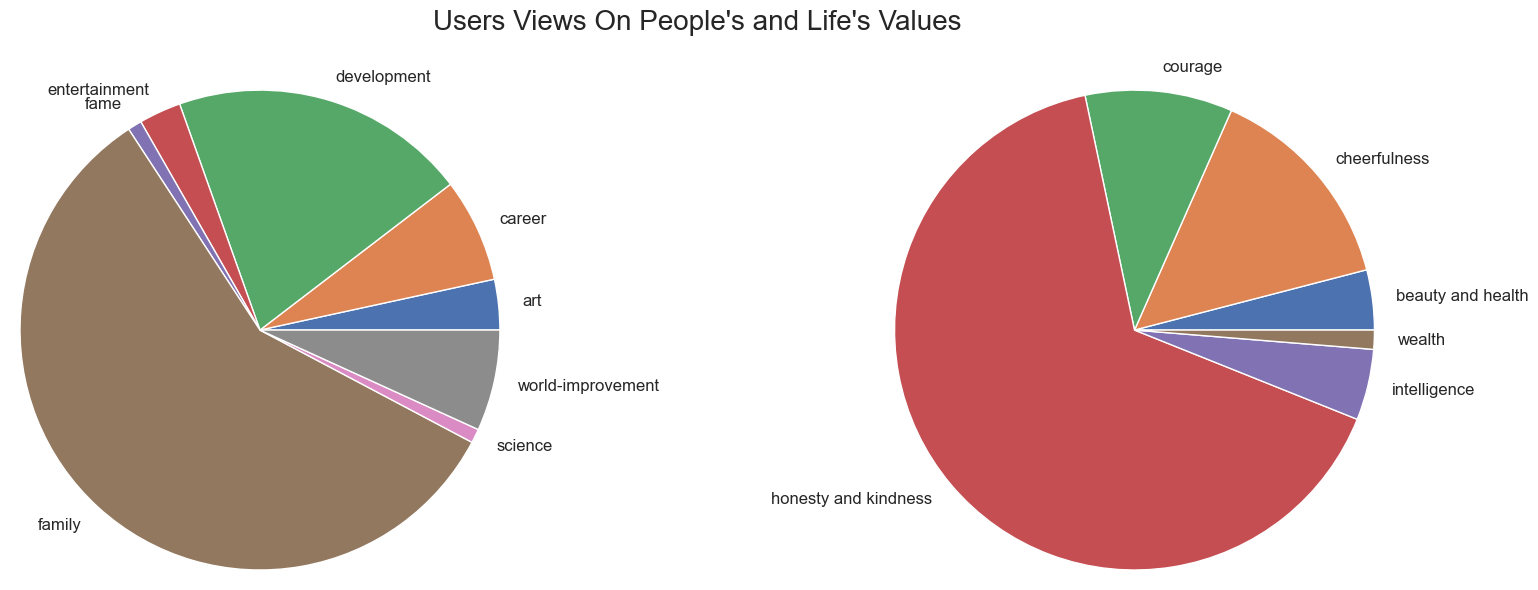

In [33]:
# Distribution Visualisation
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
figure.suptitle(
    t = "Users Views On People's and Life's Values",
    fontsize=20
)
figure.set_tight_layout(True)

ax1.pie(
    life_main_sizes,
    labels=life_main_labels,
    radius = 1.2
)
ax2.pie(
    people_main_sizes,
    labels=people_main_labels,
    radius=1.2
)

sns.despine()

#Saving Distribution
plt.savefig(
    fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/life_people_values',
    format = 'png',
    bbox_inches = 'tight'
)

### 5.4 Users Distribution By Languages

In [34]:
# Users Distribution By Languages
users_by_language = users_data \
    .groupby('languages', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .sort_values('users_count', ascending=False) \

# Distinct Top-5 Languages 
top_languages = users_by_language.loc[users_by_language.languages != 'unknown'].head(5)

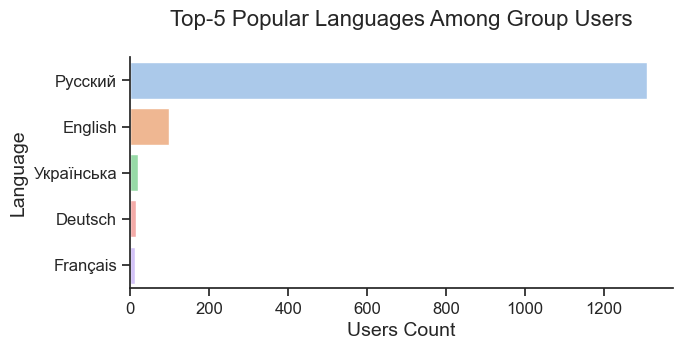

In [35]:
# Distribution Visualisation
top_languages_dist = sns.barplot(x='users_count', y='languages', data=top_languages, palette='pastel')
top_languages_dist.set(
    title = 'Top-5 Popular Languages Among Group Users\n',
    ylabel = 'Language',
    xlabel = 'Users Count'
)

sns.despine()

# Saving Distribution
plt.savefig(
    fname='/Users/aleksejpopov/Desktop/Y_Analysis/plots/popular_languages',
    format = 'png',
    bbox_inches = 'tight'
)

## 6. Final Table Styling

In [36]:
# Set Styles
cell_hover = {
    "selector": "td:hover",
    "props": [("background-color", "#FFFFE0")]
}
index_names = {
    "selector": ".index_name",
    "props": "font-style: italic; color: darkgrey; font-weight:normal;"
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #800000; color: white;"
}

users_data.style.set_table_styles([cell_hover, index_names, headers])

In [1286]:
# Saving Final Table
users_data.to_csv(
    path_or_buf = '/Users/aleksejpopov/Desktop/Y_Analysis/followers_data.csv',
    sep = ',',
    index = False
    )

## Appendix A: Interactive Charts

### Followers Distribution By Sex

In [75]:
# Creating Interactive Plot
users_by_sex_idist = px.pie(
    users_by_sex,
    values = 'users_count',
    names = 'sex',
    title = 'Followers Distribution By Sex',
    color_discrete_sequence = ['mediumturquoise', 'darkorange', 'lightgreen']
)
users_by_sex_idist.show()

# Saving Interactive Plot
users_by_sex_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/sex_dist.html')

### Followers Distribution By Sex and Age

In [76]:
# Creating Interactive Plot
users_data = users_data.replace({'sex':{0:'unknown', 1:'female', 2:'male'}})
users_by_sex_age_idist = px.histogram(
    users_data,
    x = 'age',
    y = 'id',
    color = 'sex',
    color_discrete_sequence = ['coral', 'forestgreen'],
    title = 'Users Distribution By Sex and Age'
)
users_by_sex_age_idist.show()

# Saving Interactive Plot
users_by_sex_age_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/sex_age_dist.html')

### Followers Distribution By Age Categories

In [77]:
# Creating Interactive Plot
users_by_age_cat_idist = px.pie(
    users_by_age,
    values = 'users_count',
    names = 'age_cat',
    title = 'Users Distribution By Age Categories',
    color_discrete_sequence = ['pink', 'mediumturquoise', 'darkorange', 'forestgreen'],
    hole = 0.5
    
)
users_by_age_cat_idist.show()
# Saving Interactive Plot 
users_by_age_cat_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/age_cat_dist.html')

In [78]:
# Creating Interactive Plot
top_users_by_ht = top_users_by_ht.head(10)
top_users_by_ht_idist = px.bar(
    top_users_by_ht,
    x = 'current_city',
    y = 'users_count',
    title = 'Followers Distribution By Current City',
    text_auto='.2s',
    pattern_shape_sequence = ['.']
)
top_users_by_ht_idist.update_traces(
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5
)
top_users_by_ht_idist.show()

# Saving Interactive Plot
top_users_by_ht_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/city_dist.html')

### Followers Distribution By Relation

In [79]:
# Creating Interactive Plot
users_by_relation_idist = px.bar(
    users_by_relation.sort_values('users_count'),
    x = 'users_count',
    y = 'relation_cat',
    title = 'Users Distribution By Relation',
    text_auto = '.2s',
    color_discrete_sequence = ['lightsalmon']
)
users_by_relation_idist.show()

#Saving Interactive Plot
users_by_relation_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/rel_dist.html')

### Followers Distribution By Harmful Habits

In [80]:
# Creating Interactive Plot
attitude = ['compromiss', 'neutral', 'negative', 'positive', 'strictly negative']

figure = go.Figure()
figure.add_trace(go.Bar(
    x = attitude,
    y = users_by_smoking.users_count.to_list(),
    name = 'Smoking',
    marker_color = 'indianred'
))
figure.add_trace(go.Bar(
    x = attitude,
    y = users_by_alcohol.users_count.to_list(),
    name = 'Alcohol',
    marker_color = 'lightsalmon'
))
figure.show()

# Saving Interactive Plot
figure.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/habits_dist.html')

### Followers Distribution By Political Views

In [82]:
# Creating Interactive Plot
users_by_politic_idist = px.pie(
    users_by_politic,
    values = 'users_count',
    names = 'political',
    title = 'Followers Distribution By Political Views',
    hole = 0.5
    
)
users_by_politic_idist.show()

# Saving Interactive Plot
users_by_politic_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/politics_dist.html')

### Followers Distribution By People Values

In [83]:
# Creating Interactive Plot
users_by_people_main_idist = px.pie(
    users_by_people_main,
    values = 'users_count',
    names = 'people_main',
    title = 'Followers Distribution By People Values',
    hole = .5
)
users_by_people_main_idist.show()

# Saving Interactive Plot
users_by_people_main_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/people_values_dist.html')

### Followers Distribution By Life Values

In [84]:
# Creating Interactive Plot
users_by_life_main_idist = px.pie(
    users_by_life_main,
    values = 'users_count',
    names = 'life_main',
    title = 'Followers Distribution By Life Values',
    hole = .5
)
users_by_life_main_idist.show()

# Saving Interactive Plot
users_by_life_main_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/life_values_dist.html')